The aim of this notebook is to get an understanding about the data. Plots have been added to show the localization of different diseases in various region of lungs. Also UMAP(Uniform Manifold Approximation and Projection). The UMAP algorithm is competitive with t-SNE for visualization quality, and arguably preserves more of the global structure with superior run time performance. Furthermore, UMAP has no computational restrictions on embedding dimension, making it viable as a general purpose dimension reduction technique for machine learning.(https://arxiv.org/abs/1802.03426#:~:text=UMAP%20(Uniform%20Manifold%20Approximation%20and,applies%20to%20real%20world%20data.)


All images in dataset are DICOM format. So we need to convert data from DICOM to numpy array. Original dicom2array function in [raddar's notebook](https://www.kaggle.com/raddar/convert-dicom-to-np-array-the-correct-way)


In [ ]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

In [ ]:
import plotly
plotly.offline.init_notebook_mode (connected = True)

In [ ]:
img = read_xray('../input/vinbigdata-chest-xray-abnormalities-detection/train/0108949daa13dc94634a7d650a05c0bb.dicom')
plt.figure(figsize = (12,12))
plt.imshow(img, 'gray')

What if hadn't fixed MONOCHROME issue:

In [ ]:
img = read_xray('../input/vinbigdata-chest-xray-abnormalities-detection/train/0108949daa13dc94634a7d650a05c0bb.dicom', fix_monochrome = False)
plt.figure(figsize = (12,12))
plt.imshow(img, 'gray')

In [ ]:
import pandas as pd
## adding the center of each bbox
df = pd.read_csv('../input/vinbigdata-chest-xray-abnormalities-detection/train.csv')
df['x_center'] = (df['x_min'] + df['x_max'])/2
df['y_center'] = (df['y_min'] + df['y_max'])/2

In [ ]:
## Will be futher analyzed in future version of the notebook -  analysis on gender, img_height, img_width and age.


#Ref : https://www.kaggle.com/craigmthomas/localization-of-findings
# from pathlib import Path
# from pydicom import dcmread

# def add_image_dimensions_gender(df):
#     path_spec = "../input/vinbigdata-chest-xray-abnormalities-detection/train/{}.dicom"
#     height = []
#     width = []
#     gender = []
#     age = []
#     for _, row in df.iterrows():
#         dcm = dcmread(Path(path_spec.format(row["image_id"])), stop_before_pixels=True)
#         height.append(dcm.Rows)
#         width.append(dcm.Columns)
#         gender.append(dcm[0x10, 0x40].value)
#         patient_age = dcm[0x10, 0x1010].value if [0x10, 0x1010] in dcm else ""
#         age.append(patient_age)
#     df["image_height"] = height
#     df["image_width"] = width
#     df["gender"] = gender
#     df["age"] = age

# add_image_dimensions_gender(df)


In [ ]:
df.head()

In [ ]:
df.image_id.nunique()

In [ ]:
len(df)

In [ ]:
per_img_disease = len(df)/df.image_id.nunique()
print(f"therefore on average we have {per_img_disease} disease for each image")

## Distribution of diseases

In [ ]:
import seaborn as sns

In [ ]:
dist_diseases = df.class_name.value_counts()
dist_diseases

In [ ]:
import plotly.io as pio

In [ ]:
fig = dict({
    "data": [{"type": "bar",
              "x": dist_diseases.index.tolist(),
              "y": dist_diseases.values.tolist()}],
    "layout": {"title": {"text": "Occurences of Diseases"}}
})

pio.show(fig)


# How about the distribution of radiologist?

In [ ]:
radiologist_dist = df.rad_id.value_counts()
fig = dict({
    "data": [{"type": "bar",
              "x": radiologist_dist.index.tolist(),
              "y": radiologist_dist.values.tolist()}],
    "layout": {"title": {"text": "Distribution of Radiologists"}}
})

pio.show(fig)

In [ ]:
radiologist_dist_by_percentage = (radiologist_dist*100)/len(df)
fig = dict({
    "data": [{"type": "bar",
              "x": radiologist_dist_by_percentage.index.tolist(),
              "y": radiologist_dist_by_percentage.values.tolist()}],
    "layout": {"title": {"text": "Distribution of Radiologists 2"}}
})

pio.show(fig)

R8, R9, R10 are the most occuring radiologists. lets see which is the most frequently marked disease by these people.

In [ ]:
rad_ids = ['R8', 'R9', 'R10']
for rad_id in rad_ids:
    rad_df = df[df.rad_id == rad_id]
    rad_df_disease_distribution = rad_df.class_name.value_counts()


    fig = dict({
        "data": [{"type": "bar",
                  "x": rad_df_disease_distribution.index.tolist(),
                  "y": rad_df_disease_distribution.values.tolist()}],
        "layout": {"title": {"text": f"Distribution of Disease by {rad_id}"}}
    })

    pio.show(fig)

In [ ]:
df.head()


## lets see the location of bounding boxes for each diseases

In [ ]:
unique_class_names = df.class_name.unique()
unique_class_names

In [ ]:
import plotly.express as px

Now finding the centroid of each bounding boxes to draw the density plot for each disease


In [ ]:
fig, axes = plt.subplots(4 ,4, figsize = (20, 18))
for i, d in enumerate(unique_class_names):
    if d == "No finding":
        continue
    disease_df = df[df.class_name == d]
    axes[i//4, i%4 - 1].hist2d(disease_df['x_center'].values.tolist(),disease_df['y_center'].values.tolist(), bins = [np.arange(0,3500,100),np.arange(0,3500,100)])
    axes[i//4, i%4 - 1].set_title(d)

## Area Distribution By Disease

In [ ]:
df['area'] = (df['x_max'] - df['x_min']) * (df['y_max'] - df['y_min'])/(2800 * 3100)

In [ ]:
plt.figure(figsize=(20, 16))
ax = sns.boxplot(x="area", y="class_name", data=df, orient="h")
ax.set_title("Distribution of Bounding box area by Diseases")

## UMAP - Plotting the dataframe data on 2 dimension

In [ ]:
import umap

In [ ]:
reducer = umap.UMAP()

In [ ]:
df.head()

In [ ]:
# converting the categorical data to numerical data
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

In [ ]:

# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
df['rad_id_numerical'] = labelencoder.fit_transform(df['rad_id'])
df.head()

In [ ]:
## removing the nan values corresponding to this class
df_with_valid_class = df[df.class_name!='No finding']

In [ ]:
# verifying 
df_with_valid_class.isna().sum(axis=0)

In [ ]:
len(df_with_valid_class)

In [ ]:
df_data = df_with_valid_class[
    [
        "rad_id_numerical",
        "x_min",
        "y_min",
        "x_max",
        "y_max",
        "x_center",
        "y_center",
        "area"
    ]
].values
scaled_df_data = StandardScaler().fit_transform(df_data)

In [ ]:
scaled_df_data.shape

In [ ]:
embedding = reducer.fit_transform(scaled_df_data)
embedding.shape

In [ ]:
disease_map = {cn:i for i, cn in enumerate(unique_class_names)}

In [ ]:
disease_map, len(disease_map)

In [ ]:
# plt.figure(figsize=(16, 16))
# plt.scatter(embedding[:, 0], embedding[:, 1], c = df_with_valid_class.class_name.map(disease_map).values, cmap='Spectral', s=15)
# plt.gca().set_aspect('equal', 'datalim')
# plt.colorbar(boundaries=np.arange(16)-0.5).set_ticks(np.arange(15))
# plt.title('UMAP projection of the dataset', fontsize=24);


In [ ]:
embedding_df = pd.DataFrame({'y':embedding[:, 0], 'x': embedding[:, 1]})

In [ ]:
embedding_df.head()

In [ ]:
import plotly.express as px
fig = px.scatter(embedding_df, x="y", y="x", color=df_with_valid_class.class_name)
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000)
fig.show()

In [ ]:
## trying to understand what is the localization of different disease

# figs, axes = plt.subplots(4, 4, figsize = (16, 14))
# for i, d in enumerate(unique_class_names):
#     if d == 'No finding':
#         continue
#     x_min_by_d = int(df[df.class_name == d].x_min.min())
#     x_max_by_d = int(df[df.class_name == d].x_max.max())
#     y_min_by_d = int(df[df.class_name == d].y_min.min())
#     y_max_by_d = int(df[df.class_name == d].y_max.max())
#     img = read_xray('../input/vinbigdata-chest-xray-abnormalities-detection/train/21a10246a5ec7af151081d0cd6d65dc9.dicom')
#     cv2.rectangle(img, (x_min_by_d, y_min_by_d), (x_max_by_d, y_max_by_d), (0, 0, 0), 3)

#     axes[i//4, i%4 - 1].imshow(img, 'gray')
    
    
    

Seems like the relative location of the diseases will be an important factor while building the model as confirmed by the 2d histogram and UMAP.

# IMAGE LEVEL EDA

1. Image with image ids and show their diseases
2. show images for specific diseases


In [ ]:
df.head()

In [ ]:
from random import randint

class_color_mapping = {cn : [randint(0, 255) for _ in range(3)] for cn in df.class_name.unique()}
class_color_mapping

In [ ]:
from tqdm import tqdm

In [ ]:
def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data

## https://www.kaggle.com/trungthanhnguyen0502/eda-vinbigdata-chest-x-ray-abnormalities
def plot_imgs(imgs, cols=4, size=7, is_rgb=True, title="", cmap='gray', scale=4):
    rows = len(imgs)//cols + 1
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate(imgs):
        if img is not None:
            img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
    plt.suptitle(title)
    plt.show()

    
def plot_imgs_with_annotations(image_ids, class_name = 'all'):
    font = cv2.FONT_HERSHEY_SIMPLEX 
    fontScale = 1
    color = (0, 0, 0) 
    thickness = 2
    scale = 4
    imgs = []
    for image_id in tqdm(image_ids, total = len(image_ids)):
        img = read_xray(path = f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{image_id}.dicom")
        if img is not None:
            img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
        boxes = df.loc[df.image_id == image_id,['x_min', 'y_min', 'x_max', 'y_max']].values//scale
        classes = df.loc[df.image_id == image_id,'class_name'].values
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        for i, box in enumerate(boxes):
            if classes[i]!='No finding' and classes[i] == class_name:
                cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), class_color_mapping[class_name], 3)
                img = cv2.putText(img, classes[i], (int(box[0]), int(box[1])), font,  fontScale, color, thickness, cv2.LINE_AA)
        imgs.append(img)
    return imgs

In [ ]:
def plotClassImages(class_to_plot):
    print(class_to_plot)
    image_ids = df.loc[df.class_name==class_to_plot, ['image_id']].values
    image_ids = image_ids.flatten()
    imgs = plot_imgs_with_annotations(image_ids[:4], class_name = class_to_plot)
    plot_imgs(imgs, title = class_to_plot)

In [ ]:
plotClassImages(unique_class_names[0])

In [ ]:
plotClassImages(unique_class_names[1])

In [ ]:
plotClassImages(unique_class_names[2])

In [ ]:
plotClassImages(unique_class_names[3])

In [ ]:
plotClassImages(unique_class_names[4])

In [ ]:
plotClassImages(unique_class_names[5])

In [ ]:
plotClassImages(unique_class_names[6])

In [ ]:
plotClassImages(unique_class_names[7])

In [ ]:
plotClassImages(unique_class_names[8])

In [ ]:
plotClassImages(unique_class_names[9])

In [ ]:
plotClassImages(unique_class_names[10])

In [ ]:
plotClassImages(unique_class_names[11])

In [ ]:
plotClassImages(unique_class_names[12])

In [ ]:
plotClassImages(unique_class_names[13])

In [ ]:
plotClassImages(unique_class_names[14])

# Image Augmentation: Albumentation

Various Image Transformation:
reduced_image_quality.jpg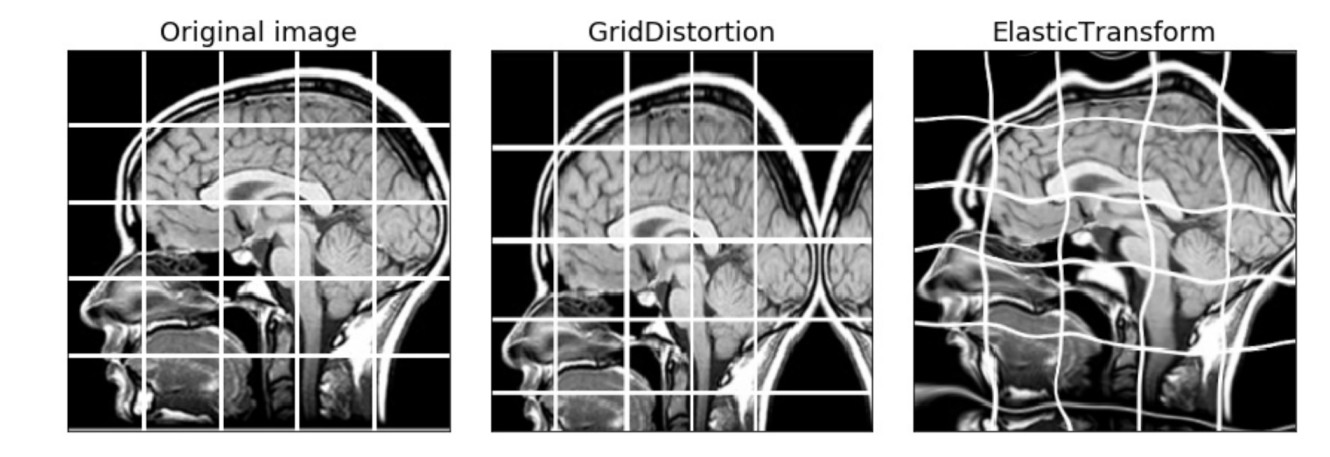

In [ ]:
df.head()

In [ ]:
image_id = "9a5094b2563a1ef3ff50dc5c7ff71345"

In [ ]:
import random

import cv2
from matplotlib import pyplot as plt

import albumentations as A

In [ ]:
def visualize(image, aug_image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)
    
def plot_aug_imgs(img, aug_img, augment_type,cols=2, size=7, is_rgb=True, title="", cmap='gray', scale=4):
    rows = 1
    subtitle = ['Original', augment_type]
    fig = plt.figure(figsize=(cols*size, rows*size))
    for i, img in enumerate([img, aug_img]):
        if img is not None:
            img = cv2.resize(img, None, fx=1/scale, fy=1/scale)
        fig.add_subplot(rows, cols, i+1)
        plt.imshow(img, cmap=cmap)
        plt.title(subtitle[i])
    plt.show()

In [ ]:
img = read_xray(path = f"../input/vinbigdata-chest-xray-abnormalities-detection/train/{image_id}.dicom")
scale = 5
if img is not None:
    img = cv2.resize(img, None, fx=1/scale, fy=1/scale)

<!-- IMAGE AUGMENTATION SAMPLE FOR MEDICAL IMAGERY
Screenshot 2021-01-29 at 4.56.06 PM![image.png](attachment:image.png) -->

In [ ]:
transform = A.GridDistortion(p=1)
random.seed(7)
augmented_image = transform(image=img)['image']
plot_aug_imgs(img, augmented_image, 'GridDistortion')

In [ ]:
transform = A.OpticalDistortion(p=1)
random.seed(7)
augmented_image = transform(image=img)['image']
plot_aug_imgs(img, augmented_image, 'Optical Distortion')

In [ ]:
transform = A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)
random.seed(7)
augmented_image = transform(image=img)['image']
plot_aug_imgs(img, augmented_image, 'Elastic Transform')